In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-06,16.871346,16.960365,16.550935,16.670353,412610800,NaN,NaN,NaN
2014-01-07,16.750681,16.934304,16.684924,16.883435,317209200,NaN,NaN,NaN
2014-01-08,16.856766,16.921901,16.708813,16.712533,258529600,NaN,NaN,NaN
2014-01-09,16.641502,16.962223,16.605212,16.960361,279148800,NaN,NaN,NaN
2014-01-10,16.530458,16.774256,16.473696,16.744168,304976000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600,54.672823,36.229135,52.092899
2023-12-26,191.243927,192.076065,191.025984,191.798686,28919300,53.090083,19.878370,38.505327
2023-12-27,191.342941,191.689673,189.302216,190.689128,48087700,53.354360,24.149983,26.752496


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

(2514, 4)
torch.Size([1996, 5, 4])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        output, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output)

        return prediction, hidden, cell    

In [6]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        x = x.permute(1,0,2) #我們的 dataloader是 [batch, seq,dim]
        y = y.permute(1,0,2) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device) 
        
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step
            outputs[i] = torch.squeeze(output,0)
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else torch.squeeze(output,0)
        
        return outputs.permute(1,0,2)

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
encoder = Encoder(input_size=4, hidden_size=128).to(device)
decoder = Decoder(output_size=4, hidden_size=128).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [8]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/aapl/seq_lstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Model saved with val_loss: 0.0173
Epoch [1/100], Train Loss: 0.0065, Val Loss: 0.0173
Epoch [2/100], Train Loss: 0.0383, Val Loss: 0.0381
Epoch [3/100], Train Loss: 0.0488, Val Loss: 0.0260
Model saved with val_loss: 0.0011
Epoch [4/100], Train Loss: 0.0159, Val Loss: 0.0011
Epoch [5/100], Train Loss: 0.0037, Val Loss: 0.0065
Epoch [6/100], Train Loss: 0.0015, Val Loss: 0.0056
Epoch [7/100], Train Loss: 0.0013, Val Loss: 0.0046
Model saved with val_loss: 0.0010
Epoch [8/100], Train Loss: 0.0006, Val Loss: 0.0010
Epoch [9/100], Train Loss: 0.0011, Val Loss: 0.0045
Epoch [10/100], Train Loss: 0.0007, Val Loss: 0.0015
Epoch [11/100], Train Loss: 0.0007, Val Loss: 0.0017
Epoch [12/100], Train Loss: 0.0008, Val Loss: 0.0027
Epoch [13/100], Train Loss: 0.0008, Val Loss: 0.0025
Epoch [14/100], Train Loss: 0.0006, Val Loss: 0.0012
Model saved with val_loss: 0.0010
Epoch [15/100], Train Loss: 0.0005, Val Loss: 0.0010
Epoch [16/100], Train Loss: 0.0008, Val Loss: 0.0024
Model saved with val_loss

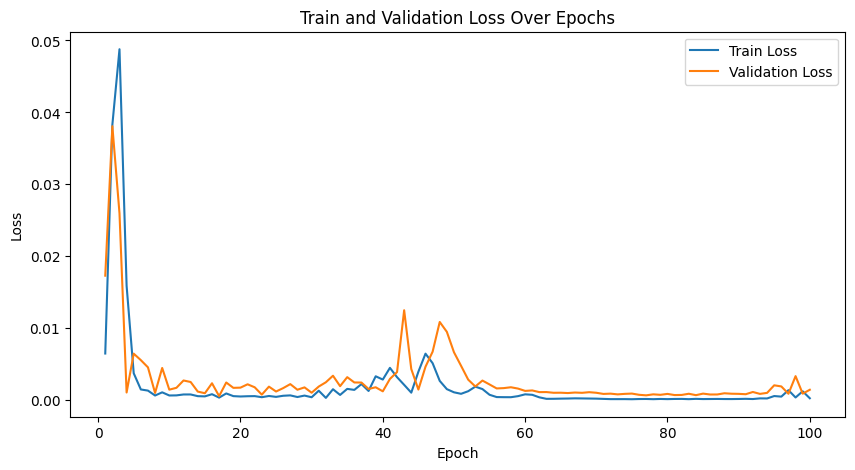

In [9]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_8896\235154986.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/aapl/seq_lstm_5.pth')


MAE:  2.2267
RMSE: 2.8198
MAPE: 1.2799%
R²:   0.9479


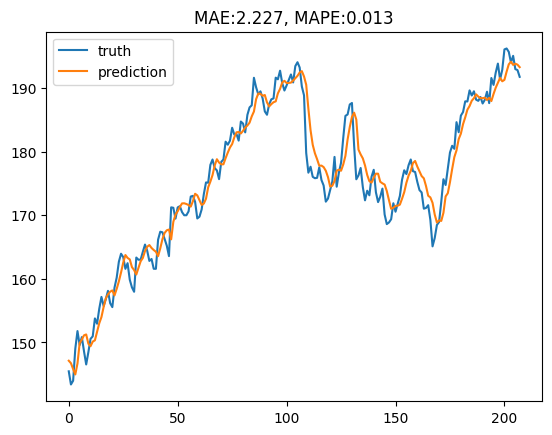

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/aapl/seq_lstm_5.pth')
model.to(device)

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-213:-5],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,145.440919,51.156447,147.109061
1,143.368974,50.113127,146.716722
2,143.960941,45.956782,145.799665
3,149.012557,47.301589,144.945980
4,151.775179,57.109919,146.681879
...,...,...,...
203,194.057324,67.991817,194.172862
204,195.097503,62.680133,193.669897
205,193.007264,64.544443,193.860529
206,192.858661,58.247505,193.708478


買入價格: 143.36897381861152
賣出價格: 151.77517944322702
cash: 1058633.284231693
額外要扣掉: 4521.502356377702
扣掉後的: 1054111.7818753154
-------------------------------------
買入價格: 150.82798859819175
賣出價格: 150.94634974546366
cash: 1054938.8895724514
額外要扣掉: 4587.805541171745
扣掉後的: 1050351.0840312797
-------------------------------------
買入價格: 155.29747402166808
賣出價格: 157.1523589007156
cash: 1062895.670468278
額外要扣掉: 4605.720130864287
扣掉後的: 1058289.9503374137
-------------------------------------
買入價格: 156.8070257627667
賣出價格: 156.16571433992303
cash: 1053962.3808560646
額外要扣掉: 4590.903143234804
扣掉後的: 1049371.4777128298
-------------------------------------
買入價格: 155.54409745350873
賣出價格: 160.19124310987362
cash: 1080721.1223106675
額外要扣掉: 4656.463638499485
扣掉後的: 1076064.6586721682
-------------------------------------
買入價格: 161.57254334021994
賣出價格: 163.00318764980395
cash: 1085591.3191296882
額外要扣掉: 4708.746747062178
扣掉後的: 1080882.5723826261
-------------------------------------
買入價格: 164.24629213683542
賣

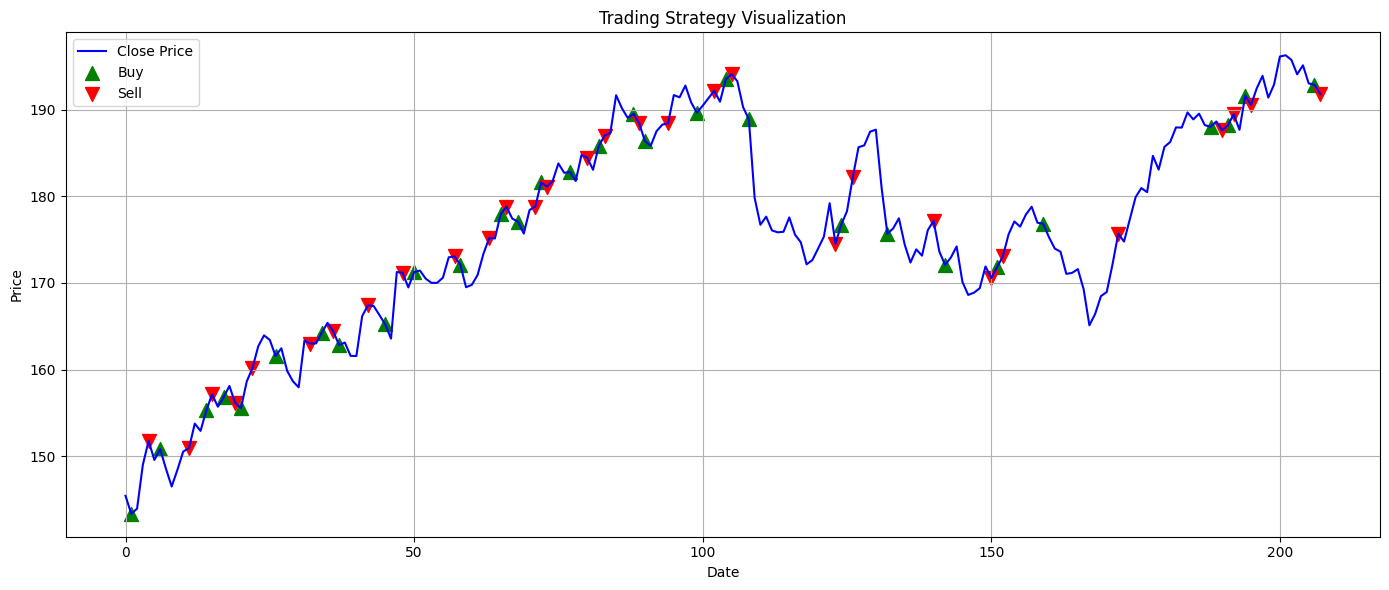

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 143.36897381861152
賣出價格: 190.15179367701367
cash: 1326310.168512355
額外要扣掉: 5304.4572428986385
扣掉後的: 1321005.7112694564
-------------------------------------
買入價格: 189.50960957503938
賣出價格: 191.78876734499968
最終價格: 1336891.4409260799


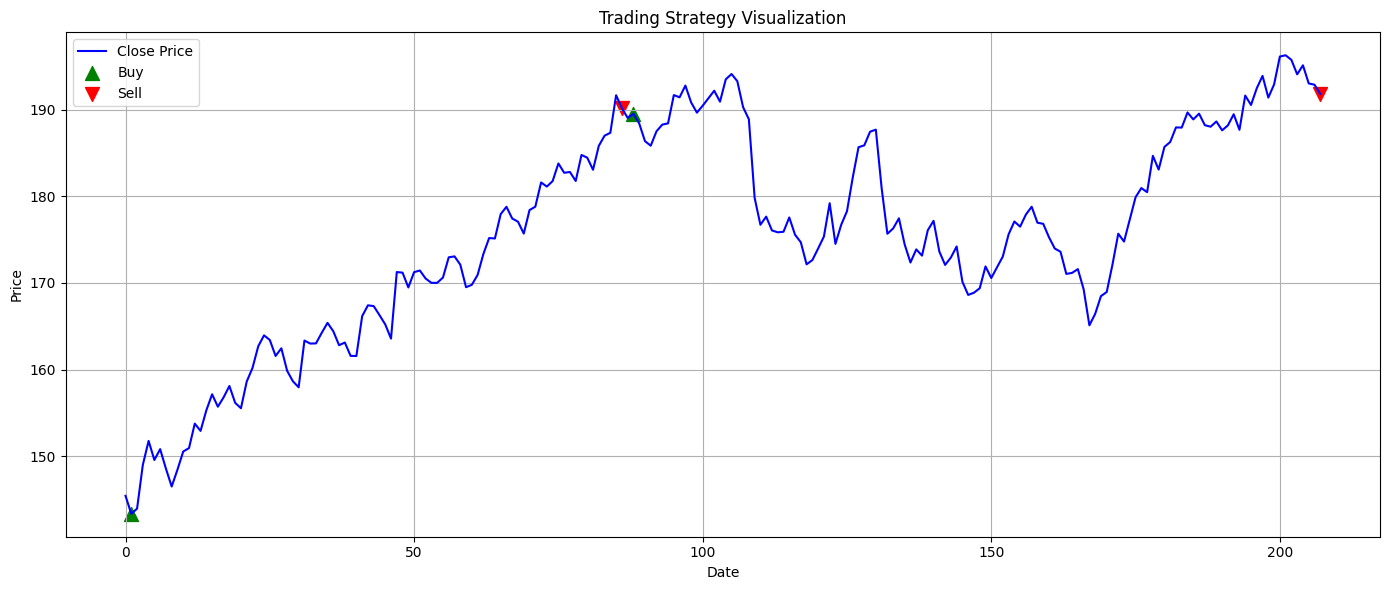

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 76.032 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
close_price_true = []
close_price_pred = []

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(208, 5)
(208, 5)
MAE:  3.4892
RMSE: 4.3295
MAPE: 1.9712%
R²:   0.8694


In [ ]:
import csv

with open('output/aapl_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('output/aapl_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)